#Questão 01

Considerando-se a base de dados de breast-cancer.csv disponível no CANVAS, pede-se:

##01.) 

Implemente a Árvore de decisão, Naive Bayes e Random Forest, em Python. Faça uma comparação destes três algoritmos utilizando as métricas, recall, precision e F1-Score, para cada uma das classes (câncer recorrente/Não recorrente). Discuta os resultados obtidos e veja se o desbalanceamento da base está prejudicando o treinamento

In [2]:
# Sistema
import sys

# Data processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Data visualization
import pickle
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Model and performance
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ConfusionMatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Oversampling and under sampling
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

### Abrindo aqruivo do csv

In [3]:
base = pd.read_csv('/content/sample_data/breast-cancer.csv', ',')
base

<ipython-input-3-64d1ad1ddd9e>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  base = pd.read_csv('/content/sample_data/breast-cancer.csv', ',')


,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events
...,...,...,...,...,...,...,...,...,...,...
281,50-59,ge40,30-34,6-8,yes,2,left,left_low,no,no-recurrence-events
282,50-59,premeno,25-29,3-5,yes,2,left,left_low,yes,no-recurrence-events
283,30-39,premeno,30-34,6-8,yes,2,right,right_up,no,no-recurrence-events
284,50-59,premeno,15-19,0-2,no,2,right,left_low,no,no-recurrence-events


In [4]:
base.rename(columns={"tumor-size": "tumorsize"}, inplace=True)
base.rename(columns={"inv-nodes": "invnodes"}, inplace=True)
base.rename(columns={"node-caps": "nodecaps"}, inplace=True)
base.rename(columns={"deg-malig": "degmalig"}, inplace=True)
base.rename(columns={"breast-quad": "breastquad"}, inplace=True)
base

,age,menopause,tumorsize,invnodes,nodecaps,degmalig,breast,breastquad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events
...,...,...,...,...,...,...,...,...,...,...
281,50-59,ge40,30-34,6-8,yes,2,left,left_low,no,no-recurrence-events
282,50-59,premeno,25-29,3-5,yes,2,left,left_low,yes,no-recurrence-events
283,30-39,premeno,30-34,6-8,yes,2,right,right_up,no,no-recurrence-events
284,50-59,premeno,15-19,0-2,no,2,right,left_low,no,no-recurrence-events


### Contando quantidade de instâncias

In [ ]:
np.unique(base['Class'], return_counts=True), sns.countplot(x = base['Class']);

In [ ]:
np.unique(base['age'], return_counts=True), sns.countplot(x = base['age'])

In [ ]:
np.unique(base['menopause'], return_counts=True), sns.countplot(x = base['menopause'])

In [ ]:
np.unique(base['tumorsize'], return_counts=True), sns.countplot(x = base['tumorsize'])

In [ ]:
np.unique(base['invnodes'], return_counts=True), sns.countplot(x = base['invnodes'])

In [ ]:
np.unique(base['degmalig'], return_counts=True), sns.countplot(x = base['degmalig'])

### Tratamento de dados ausentes (imputação de dados)

In [11]:
base.replace('?', np.nan, inplace = True)
base.isnull().sum()

age           0
menopause     0
tumorsize     0
invnodes      0
nodecaps      8
degmalig      0
breast        0
breastquad    1
irradiat      0
Class         0
dtype: int64

In [12]:
base['nodecaps'].fillna(base['nodecaps'].mode()[0], inplace=True)
base['breastquad'].fillna(base['breastquad'].mode()[0], inplace=True)

base.isnull().sum()

age           0
menopause     0
tumorsize     0
invnodes      0
nodecaps      0
degmalig      0
breast        0
breastquad    0
irradiat      0
Class         0
dtype: int64

### Separando os atributos de entrada e de classe

In [13]:
X_prev = base.iloc[:, 0:9].values
X_prev_label = base.iloc[:, 0:9]
X_prev_label

,age,menopause,tumorsize,invnodes,nodecaps,degmalig,breast,breastquad,irradiat
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no
1,50-59,ge40,15-19,0-2,no,1,right,central,no
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no
...,...,...,...,...,...,...,...,...,...
281,50-59,ge40,30-34,6-8,yes,2,left,left_low,no
282,50-59,premeno,25-29,3-5,yes,2,left,left_low,yes
283,30-39,premeno,30-34,6-8,yes,2,right,right_up,no
284,50-59,premeno,15-19,0-2,no,2,right,left_low,no


In [ ]:
y_classe = base.iloc[:, 9].values
y_classe

### Tratamento de dados categóricos

In [15]:
label_encoder = LabelEncoder()

In [16]:
X_prev_label

,age,menopause,tumorsize,invnodes,nodecaps,degmalig,breast,breastquad,irradiat
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no
1,50-59,ge40,15-19,0-2,no,1,right,central,no
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no
...,...,...,...,...,...,...,...,...,...
281,50-59,ge40,30-34,6-8,yes,2,left,left_low,no
282,50-59,premeno,25-29,3-5,yes,2,left,left_low,yes
283,30-39,premeno,30-34,6-8,yes,2,right,right_up,no
284,50-59,premeno,15-19,0-2,no,2,right,left_low,no


In [17]:
label_encoder_age = LabelEncoder()
label_encoder_menopause = LabelEncoder()
label_encoder_tumorsize = LabelEncoder()
label_encoder_invnodes = LabelEncoder()
label_encoder_nodecaps = LabelEncoder()
label_encoder_breast = LabelEncoder()
label_encoder_irradiat = LabelEncoder()

In [18]:
X_prev[:,0] = label_encoder_age.fit_transform(X_prev[:,0])
X_prev[:,1] = label_encoder_menopause.fit_transform(X_prev[:,1])
X_prev[:,2] = label_encoder_tumorsize.fit_transform(X_prev[:,2])
X_prev[:,3] = label_encoder_invnodes.fit_transform(X_prev[:,3])
X_prev[:,4] = label_encoder_nodecaps.fit_transform(X_prev[:,4])
X_prev[:,6] = label_encoder_breast.fit_transform(X_prev[:,6])
X_prev[:,8] = label_encoder_irradiat.fit_transform(X_prev[:,8])

In [ ]:
np.set_printoptions(threshold=sys.maxsize)
X_prev

### Binarizar atributos não ordinais

In [20]:
onehotencoder_base = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [7])], remainder='passthrough')
X_prev= onehotencoder_base.fit_transform(X_prev)

In [ ]:
X_prev

### Método de amostragem Holdout

In [22]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X_prev, y_classe, test_size = 0.20, random_state = 0)

In [23]:
y_classe.shape

(286,)

In [24]:
X_treino.shape

(228, 13)

In [25]:
X_teste.shape

(58, 13)

### Treinamento do modelo

#### Árvore de Decisão

In [26]:
AD_X_treino = X_treino
AD_y_treino = y_treino

AD_X_teste = X_teste
AD_y_teste = y_teste

AD_modelo = DecisionTreeClassifier(criterion='gini')
AD_modelo.fit(AD_X_treino, AD_y_treino)

DecisionTreeClassifier()

In [27]:
AD_previsoes = AD_modelo.predict(AD_X_teste)

In [28]:
accuracy_score(AD_y_teste, AD_previsoes)

0.6379310344827587

In [29]:
confusion_matrix(AD_y_teste, AD_previsoes)

array([[28,  8],
       [13,  9]])

0.6379310344827587

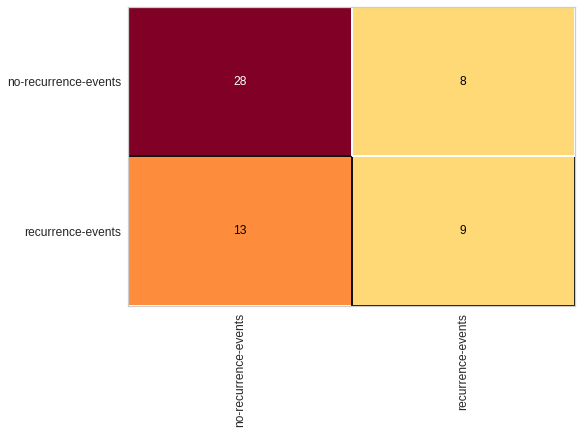

In [30]:
AD_cm = ConfusionMatrix(AD_modelo)
AD_cm.fit(AD_X_treino, AD_y_treino)
AD_cm.score(AD_X_teste, AD_y_teste)

In [31]:
print(classification_report(AD_y_teste, AD_previsoes))

                      precision    recall  f1-score   support

no-recurrence-events       0.68      0.78      0.73        36
   recurrence-events       0.53      0.41      0.46        22

            accuracy                           0.64        58
           macro avg       0.61      0.59      0.59        58
        weighted avg       0.62      0.64      0.63        58



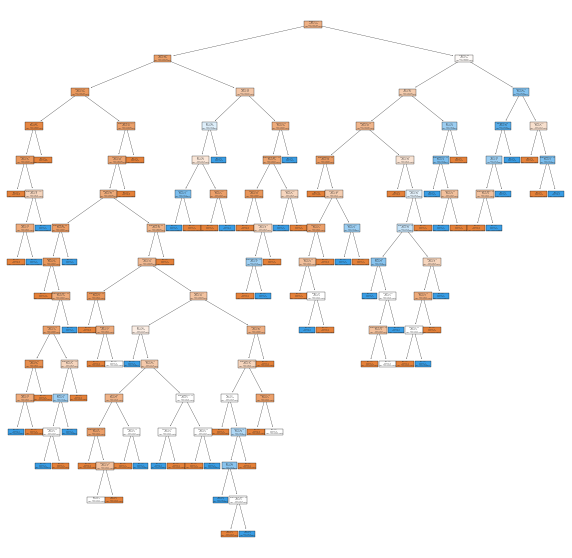

In [32]:
AD_previsores = ['breastquadleftup', 'breastquadcentral', 'breastquadhleftlow', 'breastquadhrightup', 'breastquadhrightdown', 'age', 'menopause', 'tumorsize', 'invnodes', 'nodecaps', 'degmalig', 'breast', 'irradiat']

figura, eixos = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

tree.plot_tree(AD_modelo, feature_names=AD_previsores, class_names = AD_modelo.classes_, filled=True);

#### Naive Bayes

In [33]:
NB_X_treino = X_treino
NB_y_treino = y_treino

NB_X_teste = X_teste
NB_y_teste = y_teste

NB_modelo = GaussianNB()
NB_modelo.fit(X_treino, y_treino)

NB_previsoes = NB_modelo.predict(NB_X_teste)

In [34]:
accuracy_score(NB_y_teste, NB_previsoes)

0.7413793103448276

In [35]:
confusion_matrix(NB_y_teste, NB_previsoes)

array([[31,  5],
       [10, 12]])

0.7413793103448276

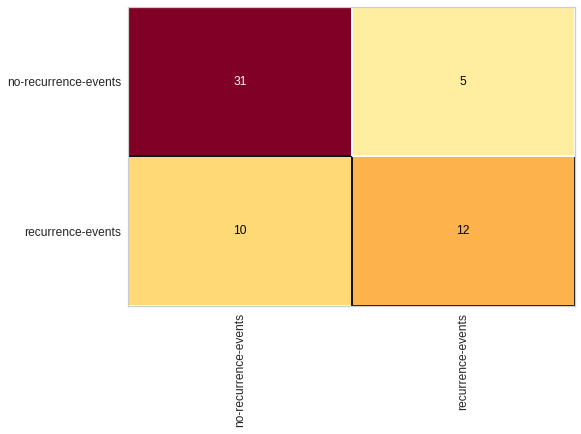

In [36]:
NB_cm = ConfusionMatrix(NB_modelo)
NB_cm.fit(NB_X_treino, NB_y_treino)
NB_cm.score(NB_X_teste, NB_y_teste)

In [37]:
print(classification_report(NB_y_teste, NB_previsoes))

                      precision    recall  f1-score   support

no-recurrence-events       0.76      0.86      0.81        36
   recurrence-events       0.71      0.55      0.62        22

            accuracy                           0.74        58
           macro avg       0.73      0.70      0.71        58
        weighted avg       0.74      0.74      0.73        58



#### Random Forest

In [38]:
RF_X_treino = X_treino
RF_y_treino = y_treino

RF_X_teste = X_teste
RF_y_teste = y_teste

RF_modelo = RandomForestClassifier(n_estimators=100, max_features=6, criterion='gini', random_state = 0)
RF_modelo.fit(RF_X_treino, RF_y_treino)

RF_previsoes = RF_modelo.predict(RF_X_teste)

In [39]:
accuracy_score(RF_y_teste, RF_previsoes)

0.6896551724137931

In [40]:
confusion_matrix(RF_y_teste, RF_previsoes)

array([[32,  4],
       [14,  8]])

0.6896551724137931

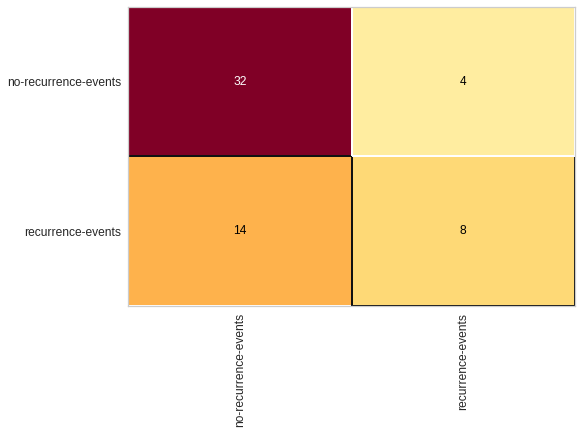

In [41]:
RF_cm = ConfusionMatrix(RF_modelo)
RF_cm.fit(RF_X_treino, RF_y_treino)
RF_cm.score(RF_X_teste, RF_y_teste)

In [42]:
print(classification_report(RF_y_teste, RF_previsoes))

                      precision    recall  f1-score   support

no-recurrence-events       0.70      0.89      0.78        36
   recurrence-events       0.67      0.36      0.47        22

            accuracy                           0.69        58
           macro avg       0.68      0.63      0.63        58
        weighted avg       0.68      0.69      0.66        58



### Treinamento com balanceamento dos dados usando um método undersampling

In [43]:
balanceamento_under = TomekLinks(sampling_strategy='auto')
X_under, y_under = balanceamento_under.fit_resample(X_treino, y_treino)

In [44]:
X_under.shape, y_under.shape

((213, 13), (213,))

In [45]:
np.unique(y_treino, return_counts=True)

(array(['no-recurrence-events', 'recurrence-events'], dtype=object),
 array([165,  63]))

In [46]:
np.unique(y_under, return_counts=True)

(array(['no-recurrence-events', 'recurrence-events'], dtype=object),
 array([150,  63]))

#### Árvore de Decisão

In [47]:
AD2_X_under = X_under
AD2_y_under = y_under

AD2_X_teste = X_teste
AD2_y_teste = y_teste

AD2_modelo = DecisionTreeClassifier(criterion='gini')
AD2_modelo.fit(AD2_X_under, AD2_y_under)

DecisionTreeClassifier()

In [48]:
AD2_previsoes = AD2_modelo.predict(AD2_X_teste)

In [49]:
accuracy_score(AD2_y_teste, AD2_previsoes)

0.5517241379310345

In [50]:
confusion_matrix(AD2_y_teste, AD2_previsoes)

array([[25, 11],
       [15,  7]])

0.5517241379310345

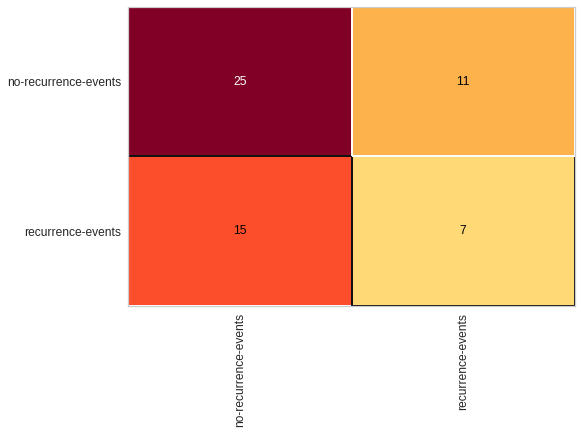

In [51]:
AD2_cm = ConfusionMatrix(AD2_modelo)
AD2_cm.fit(AD2_X_under, AD2_y_under)
AD2_cm.score(AD2_X_teste, AD2_y_teste)

In [52]:
print(classification_report(AD2_y_teste, AD2_previsoes))

                      precision    recall  f1-score   support

no-recurrence-events       0.62      0.69      0.66        36
   recurrence-events       0.39      0.32      0.35        22

            accuracy                           0.55        58
           macro avg       0.51      0.51      0.50        58
        weighted avg       0.54      0.55      0.54        58



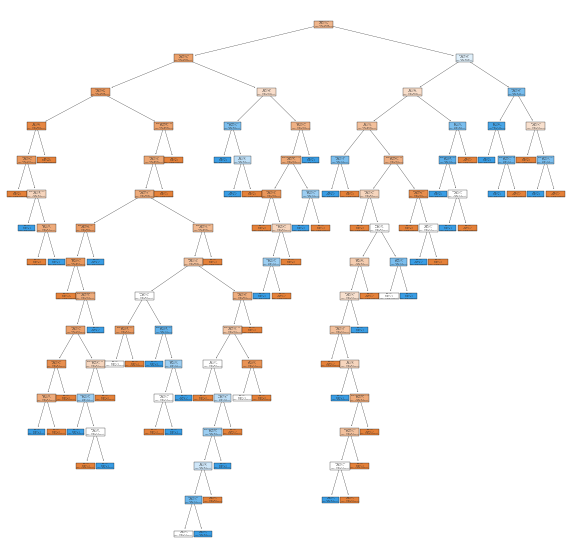

In [53]:
AD2_previsores = ['breastquadleftup', 'breastquadcentral', 'breastquadhleftlow', 'breastquadhrightup', 'breastquadhrightdown', 'age', 'menopause', 'tumorsize', 'invnodes', 'nodecaps', 'degmalig', 'breast', 'irradiat']

figura, eixos = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

tree.plot_tree(AD2_modelo, feature_names=AD2_previsores, class_names = AD2_modelo.classes_, filled=True);

#### Naive Bayes

In [54]:
NB2_X_under = X_under
NB2_y_under = y_under

NB2_X_teste = X_teste
NB2_y_teste = y_teste

NB2_modelo = GaussianNB()
NB2_modelo.fit(NB2_X_under, NB2_y_under)

NB2_previsoes = NB2_modelo.predict(NB2_X_teste)

In [55]:
accuracy_score(NB2_y_teste,NB2_previsoes)

0.7586206896551724

In [56]:
confusion_matrix(NB2_y_teste, NB2_previsoes)

array([[31,  5],
       [ 9, 13]])

0.7586206896551724

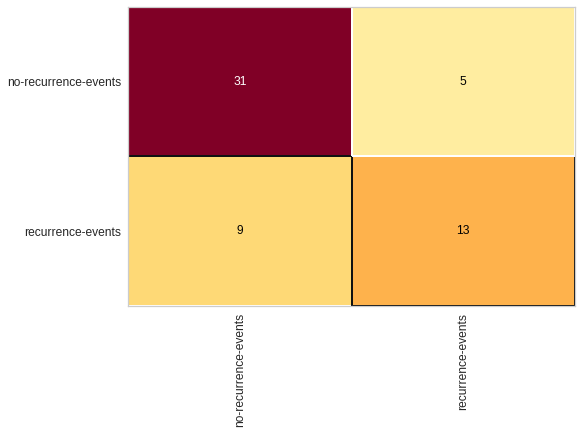

In [57]:
NB2_cm = ConfusionMatrix(NB2_modelo)
NB2_cm.fit(NB2_X_under, NB2_y_under)
NB2_cm.score(NB2_X_teste, NB2_y_teste)

In [58]:
print(classification_report(NB2_y_teste, NB2_previsoes))

                      precision    recall  f1-score   support

no-recurrence-events       0.78      0.86      0.82        36
   recurrence-events       0.72      0.59      0.65        22

            accuracy                           0.76        58
           macro avg       0.75      0.73      0.73        58
        weighted avg       0.75      0.76      0.75        58



#### Random Forest

In [59]:
RF2_X_under = X_under
RF2_y_under = y_under

RF2_X_teste = X_teste
RF2_y_teste = y_teste

RF2_modelo = RandomForestClassifier(n_estimators=100, max_features=6, criterion='gini', random_state = 0)
RF2_modelo.fit(RF2_X_under, RF2_y_under)

RF2_previsoes = RF2_modelo.predict(RF2_X_teste)

In [60]:
accuracy_score(RF2_y_teste, RF2_previsoes)

0.7241379310344828

In [61]:
confusion_matrix(RF2_y_teste, RF2_previsoes)

array([[33,  3],
       [13,  9]])

0.7241379310344828

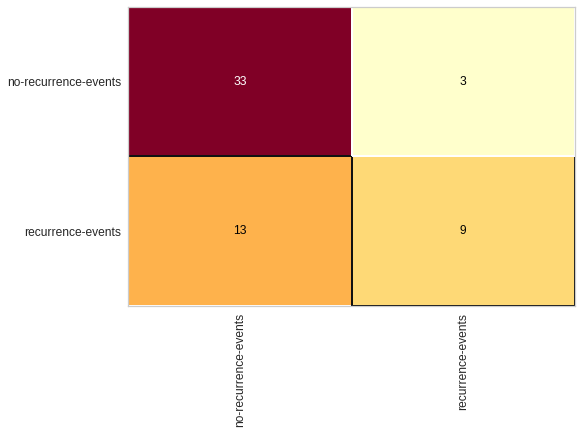

In [62]:
RF2_cm = ConfusionMatrix(RF2_modelo)
RF2_cm.fit(RF2_X_under, RF2_y_under)
RF2_cm.score(RF2_X_teste, RF2_y_teste)

In [63]:
print(classification_report(RF2_y_teste, RF2_previsoes))

                      precision    recall  f1-score   support

no-recurrence-events       0.72      0.92      0.80        36
   recurrence-events       0.75      0.41      0.53        22

            accuracy                           0.72        58
           macro avg       0.73      0.66      0.67        58
        weighted avg       0.73      0.72      0.70        58



### Treinamento com balanceamento de dados usando o método oversampling

In [64]:
# Randomly over sample the minority class
balanceamento_over = SMOTE(sampling_strategy = 'auto')
X_over, y_over = balanceamento_over.fit_resample(X_treino, y_treino)

In [65]:
X_over.shape, y_over.shape

((330, 13), (330,))

In [66]:
np.unique(y_treino, return_counts=True)

(array(['no-recurrence-events', 'recurrence-events'], dtype=object),
 array([165,  63]))

In [67]:
np.unique(y_over, return_counts=True)

(array(['no-recurrence-events', 'recurrence-events'], dtype=object),
 array([165, 165]))

#### Árvore de Decisão

In [68]:
AD3_X_over = X_over
AD3_y_over = y_over

AD3_X_teste = X_teste
AD3_y_teste = y_teste

AD3_modelo = DecisionTreeClassifier(criterion = 'gini')
AD3_modelo.fit(AD3_X_over, AD3_y_over)

DecisionTreeClassifier()

In [69]:
AD3_previsoes = AD3_modelo.predict(AD3_X_teste)

In [70]:
accuracy_score(AD3_y_teste, AD3_previsoes)

0.5517241379310345

In [71]:
confusion_matrix(AD3_y_teste, AD3_previsoes)

array([[24, 12],
       [14,  8]])

0.5517241379310345

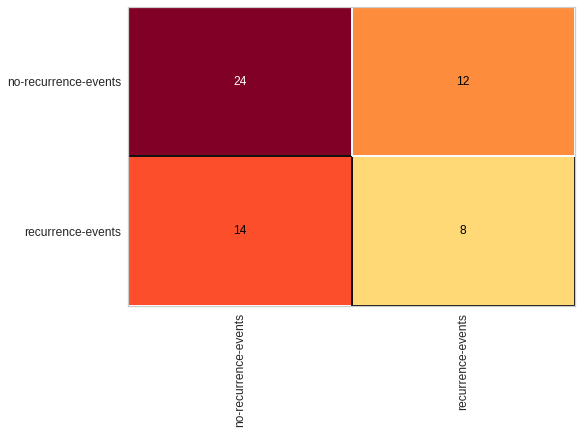

In [72]:
AD3_cm = ConfusionMatrix(AD3_modelo)
AD3_cm.fit(AD3_X_over, AD3_y_over)
AD3_cm.score(AD3_X_teste, AD3_y_teste)

In [73]:
print(classification_report(AD3_y_teste, AD3_previsoes))

                      precision    recall  f1-score   support

no-recurrence-events       0.63      0.67      0.65        36
   recurrence-events       0.40      0.36      0.38        22

            accuracy                           0.55        58
           macro avg       0.52      0.52      0.51        58
        weighted avg       0.54      0.55      0.55        58



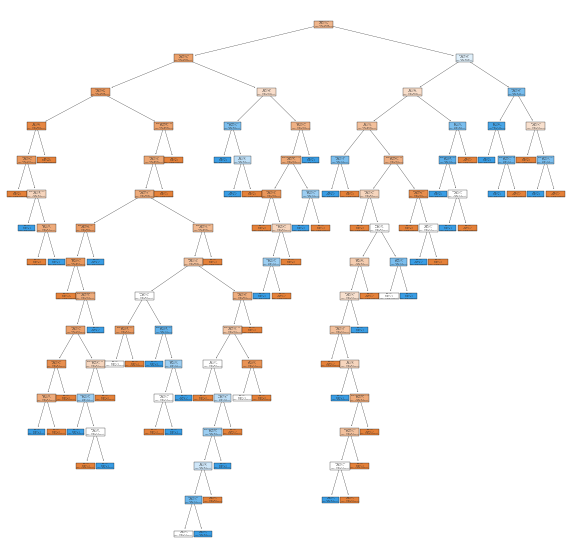

In [74]:
AD3_previsores = ['breastquadleftup', 'breastquadcentral', 'breastquadhleftlow', 'breastquadhrightup', 'breastquadhrightdown', 'age', 'menopause', 'tumorsize', 'invnodes', 'nodecaps', 'degmalig', 'breast', 'irradiat']

figura, eixos = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

tree.plot_tree(AD2_modelo, feature_names=AD3_previsores, class_names = AD3_modelo.classes_, filled=True);

#### Naive Bayes

In [75]:
NB3_X_over = X_over
NB3_y_over = y_over

NB3_X_teste = X_teste
NB3_y_teste = y_teste

NB3_modelo = GaussianNB()
NB3_modelo.fit(NB3_X_over, NB3_y_over)

NB3_previsoes = NB3_modelo.predict(NB3_X_teste)

In [76]:
accuracy_score(NB3_y_teste,NB3_previsoes)

0.6724137931034483

In [77]:
confusion_matrix(NB3_y_teste, NB3_previsoes)

array([[25, 11],
       [ 8, 14]])

0.6724137931034483

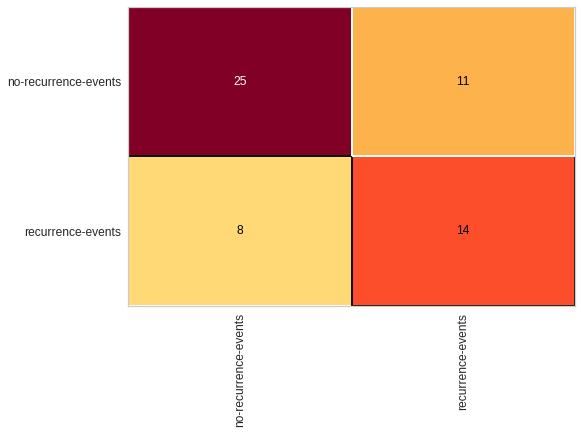

In [78]:
NB3_cm = ConfusionMatrix(NB3_modelo)
NB3_cm.fit(NB3_X_over, NB3_y_over)
NB3_cm.score(NB3_X_teste, NB3_y_teste)

In [79]:
print(classification_report(NB3_y_teste, NB3_previsoes))

                      precision    recall  f1-score   support

no-recurrence-events       0.76      0.69      0.72        36
   recurrence-events       0.56      0.64      0.60        22

            accuracy                           0.67        58
           macro avg       0.66      0.67      0.66        58
        weighted avg       0.68      0.67      0.68        58



#### Random Forest

In [80]:
RF3_X_over = X_over
RF3_y_over = y_over

RF3_X_teste = X_teste
RF3_y_teste = y_teste

RF3_modelo = RandomForestClassifier(n_estimators=100, max_features=6, criterion='gini', random_state = 0)
RF3_modelo.fit(RF3_X_over, RF3_y_over)

RF3_previsoes = RF3_modelo.predict(RF3_X_teste)

In [81]:
accuracy_score(RF3_y_teste, RF3_previsoes)

0.7068965517241379

In [82]:
confusion_matrix(RF2_y_teste, RF2_previsoes)

array([[33,  3],
       [13,  9]])

0.7068965517241379

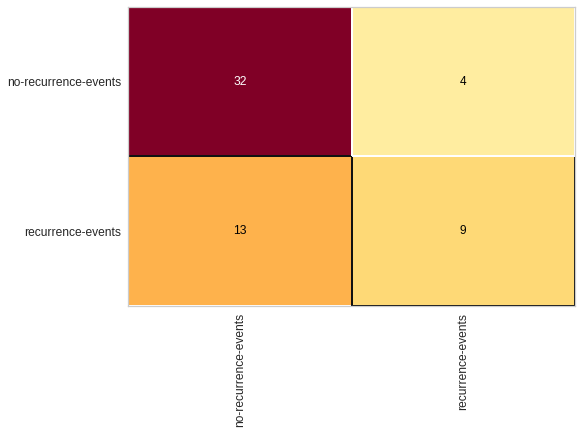

In [83]:
RF3_cm = ConfusionMatrix(RF3_modelo)
RF3_cm.fit(RF3_X_over, RF3_y_over)
RF3_cm.score(RF3_X_teste, RF3_y_teste)

In [84]:
print(classification_report(RF3_y_teste, RF3_previsoes))

                      precision    recall  f1-score   support

no-recurrence-events       0.71      0.89      0.79        36
   recurrence-events       0.69      0.41      0.51        22

            accuracy                           0.71        58
           macro avg       0.70      0.65      0.65        58
        weighted avg       0.70      0.71      0.69        58

